In [136]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem 1

**Part A: Model Setup**

In [137]:
# Excitatory Params
N = 100  # Number of excitatory neurons on the ring
A = 1.0 # Amplitude of excitatory connections
sigma_w = 2  # Width of excitatory connections

#Time Constants
tau = 1.0  # Time constant for excitatory neurons
tau_0 = 1.0  # Time constant for inhibitory neuron

# Activation Paramets
beta = 10  # Steepness parameter for sigmoid
theta = 1.0  # Threshold parameter for sigmoid

# Inhibitory Params
w_inh = 2.8 # Strength of inhibitory feedback
w_0 = 0.3  # Weight from excitatory to inhibitory

In [138]:
# Weight Matrix
W = np.zeros((N,N))  # Create N x N matrix of zeros
for i in range(N):
    for j in range(N):
        distance = min(abs(i-j), N-abs(i-j))
        W[i][j] = A * np.exp(-(distance**2)/(2*(sigma_w**2)))

In [139]:
# Sigmoid Activation Function
def f(z):
    return 1/(1+np.exp(-beta*(z-theta)))

In [140]:
# Network dynamics
# For excitatory neurons τ(dri/dt) = -ri + F(∑wij*rj + Ii(t) - winh*r0)
# For inhibitory neurons τ0(dr0/dt) = -r0 + F(∑w0*rj)

def network_dynamics(t, r, I = None):
    # t is the current timepoint
    # r is the current state of the network
    # r[0] represents the center inhibitory neuron activity
    # r[1:N+1] is the activity of the ring of the excitatory neurons
    # We'll use r (current firing rates) to compute dr (rate of change)
    # Then update r based on dr (r = r + dt * dr)
    # I represents Input, this variable is optional
    # If no I (input vector) is passed, by default it will be set to None
    if I is None:
        #set I = to a vector of zeros size N
        I = np.zeros(N)
    

    dr = np.zeros(N+1) #Matrix representing the rate of change for each neuron's activity

    # Implement Inhibitory Diff Equation
    inh_input = np.sum(w_0 * r[1:])
    dr[0] = (-r[0] + f(inh_input)) / tau_0

    # Implement Excitatory Diff Equation and set rate of change for each neuron
    for i in range(N):
        exc_input = 0
        # For each neuron calculate exitatory input
        for j in range(N):
            exc_input += W[i][j] * r[j+1]
        
        total_input = exc_input + I[i] - w_inh * r[0]
        
        dr[i+1] = (-r[i+1] + f(total_input)) / tau

    return dr

Note: Claude was used to help implement the network dynamics function
Prompts:
* "What are the numpy operation calls to implement the following differential equations in python"
* "I want to make it so that I is an optional variable. If I is not present, I want it to be set to a vector of zeros size N. Could is just say def network_dyanamics(t, r, I = np.zeros(N)"


**Part B: Simulations**

In [154]:
# Stable Bump Attractor
dt = .01 #Time step
T = 60 # Total Time for the Simulation
#Vector of time values starting at 0 and running to T (inclusive) stepping dt each time
time = np.arange(0, T+dt, dt) 
numSteps = len(time)

# Redeclare these variables here in this cell for testing.
# Many simulations were needed to find the optimal excitation and inhibition balance.
w_inh = 1.5
w_0 = .3  
A = 1.0

# Set Baseline activity to 0
# N x numSteps Matrix representing activity of excitatory neurons at each time point
r_exc = np.zeros((N, numSteps))

# 1 x numSteps Matrix representing activity of inhibitory neuron at each time point
r_inh = np.zeros(numSteps)

# Bump activity at neuron 50 (halfway point of our 100 neurons)
bump_center = 50 
bump_width = 5
for i in range(N):
    r_exc[i,0] = np.exp(-((i-bump_center)**2)/(2*bump_width**2))

r_inh[0] = 0 # It should already be set to 0 when we intialize the matrix but to be sure.

# Run simulation of network given the bump
r_current = np.zeros(N+1) #Initial Matrix containing every neurons activity at timepoint t

for t in range(numSteps - 1):
    r_current[0] = r_inh[t] #Set Inhibitory Activity
    r_current[1:] = r_exc[:, t] #Set excitatory Neuron activity

    # Get Rates of Change for each neuron
    dr = network_dynamics(time[t], r_current)


    # Update using Euler Method
    r_inh[t+1] = r_inh[t] + dt * dr[0]
    r_exc[:, t+1] = r_exc[:, t] + dt * dr[1:]

Note: Claude was used in this section
* "How can i make a time vector starting from 0 and running to 15 stepping .01"
* "How would I create a small initial bump, what are the parameters of a bump? Is it just the neuron I would want to stimulate like 50 and how many neurons on either side should recieve some excitation from the bump?"
* "Is there a standard equation for creating an activity bump? I'm guessing it's going to be some sort of gaussian function because we want our center point and then set a width for the bump in activity for neurons withing a certain range or deviation?"
* "What are some ways we could go about solving the differential equations in our simulation? Remind me about the Euler Method for updating the neuron's activity. This should be a simple way to solve a differential equation, correct?"     

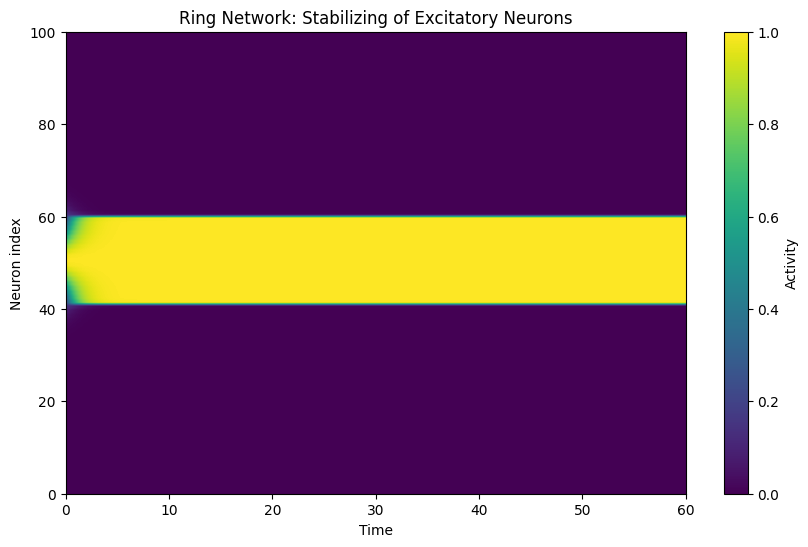

In [155]:
# Visualize Bump Stabilization

plt.figure(figsize=(10,6))
plt.imshow(r_exc, aspect = 'auto', origin='lower', cmap='viridis', extent = [0,T,0,N])
plt.colorbar(label='Activity')
plt.xlabel('Time')
plt.ylabel('Neuron index')
plt.title('Ring Network: Stabilizing of Excitatory Neurons')
plt.show()


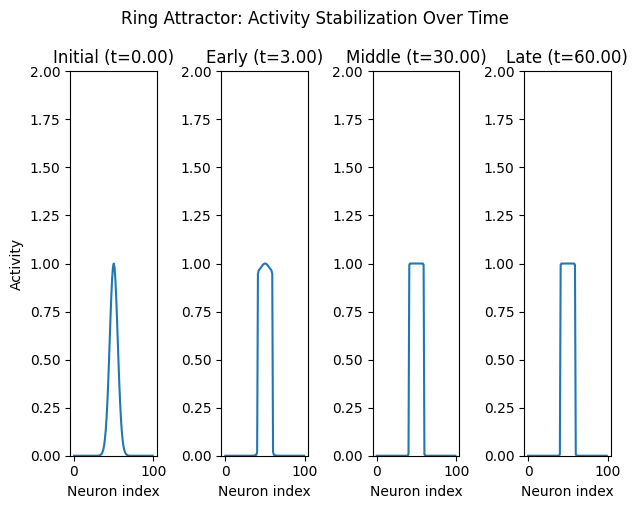

In [156]:
# To further illustrate the point that network activity stabilizes
plt.figure()

early = int(numSteps * 0.05)    # 5% of the way through (early)
middle = int(numSteps * 0.5)    # 50% of the way through (middle)
late = numSteps - 1             # Last timepoint (late)

timepoints = [0, early, middle, late]
labels = ['Initial', 'Early', 'Middle', 'Late']

for i, t_idx in enumerate(timepoints):
    plt.subplot(1, 4, i+1)
    plt.plot(range(N), r_exc[:, t_idx])
    plt.title(f'{labels[i]} (t={time[t_idx]:.2f})')
    plt.xlabel('Neuron index')
    if i == 0:
        plt.ylabel('Activity')
    plt.ylim(0, 2) 

plt.tight_layout()
plt.suptitle('Ring Attractor: Activity Stabilization Over Time', y=1.05)
plt.show()

Note: Claude was used in this section
* "Remind me of matplotlib heatmap function"
* "Remind me, what functions are need to make a multipanel plot in matplot lib"

In [157]:
# Stimulus-Driven Bump Formation
dt = 0.01  # Time step
T = 30     # Total simulation time
time = np.arange(0, T+dt, dt)
numSteps = len(time)

# Initialize with small random activity instead of a bump
r_exc_stim = np.zeros((N, numSteps))
r_inh_stim = np.zeros(numSteps)

# Small random initial conditions
r_exc_stim[:, 0] = np.zeros(N)
r_inh_stim[0] = 0.2

# Create external stimulus (Gaussian centered at position 25)
stim_center = 25
stim_width = 5
stim_amplitude = 2
stim_start = 0.5  # Start time of stimulus
stim_end = 1.0    # End time of stimulus

# Create input array for all neurons at all timesteps
I_ext = np.zeros((N, numSteps))

# Set stimulus during the specified time window
stim_start_idx = int(stim_start / dt)
stim_end_idx = int(stim_end / dt)

# Apply stimulus to each neuron based on distance from stimulus center
for i in range(N):
    dist = min(abs(i - stim_center), N - abs(i - stim_center))
    stim_value = stim_amplitude * np.exp(-(dist**2) / (2*stim_width**2))
    I_ext[i, stim_start_idx:stim_end_idx] = stim_value

# Run simulation with external input
r_current = np.zeros(N+1)
for t in range(numSteps-1):
    r_current[0] = r_inh_stim[t]
    r_current[1:] = r_exc_stim[:, t]
    
    # Pass the external input for this time step
    dr = network_dynamics(time[t], r_current, I=I_ext[:, t])
    
    # Update using Euler method
    r_inh_stim[t+1] = r_inh_stim[t] + dt * dr[0]
    r_exc_stim[:, t+1] = r_exc_stim[:, t] + dt * dr[1:]

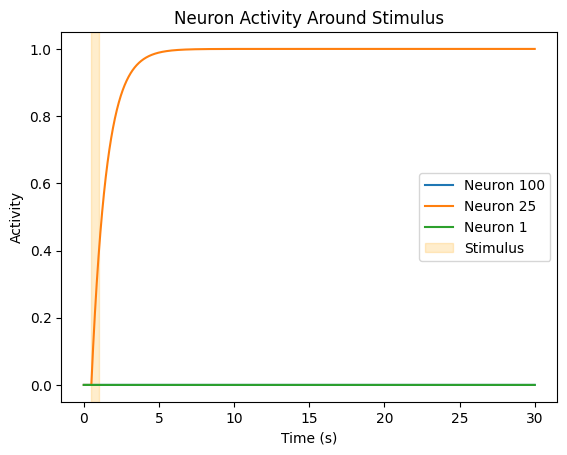

In [158]:
# Trouble shooting: I was not seeing a bump in my heat map
# The first time this plotted, it showed simulatenous activation of all neurons in my network
# From this I reran simulations adjusting the excitation/inhibition parameters to better balance the two

plt.plot(time, r_exc_stim[99], label='Neuron 100')
plt.plot(time, r_exc_stim[25], label='Neuron 25')
plt.plot(time, r_exc_stim[0], label='Neuron 1')
plt.axvspan(stim_start, stim_end, color='orange', alpha=0.2, label='Stimulus')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Activity")
plt.title("Neuron Activity Around Stimulus")
plt.show()


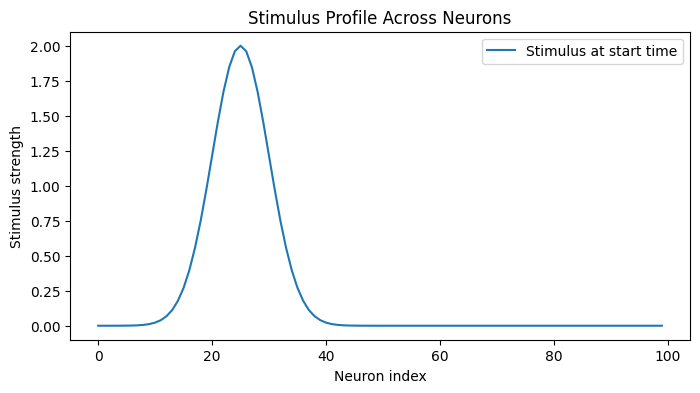

In [159]:
# Trouble shooting, verify that are stimulus is delivered to the proper neurons.
# Also note that the stimulus is a Gaussian pulse
plt.figure(figsize=(8, 4))
plt.plot(I_ext[:, stim_start_idx], label="Stimulus at start time")
plt.xlabel("Neuron index")
plt.ylabel("Stimulus strength")
plt.title("Stimulus Profile Across Neurons")
plt.legend()
plt.show()


Note: Claude was used in this this section
* Remind me of numpy's random function (I initially was creating some low random noise in the simulation at rest but later changed basline activity to 0.

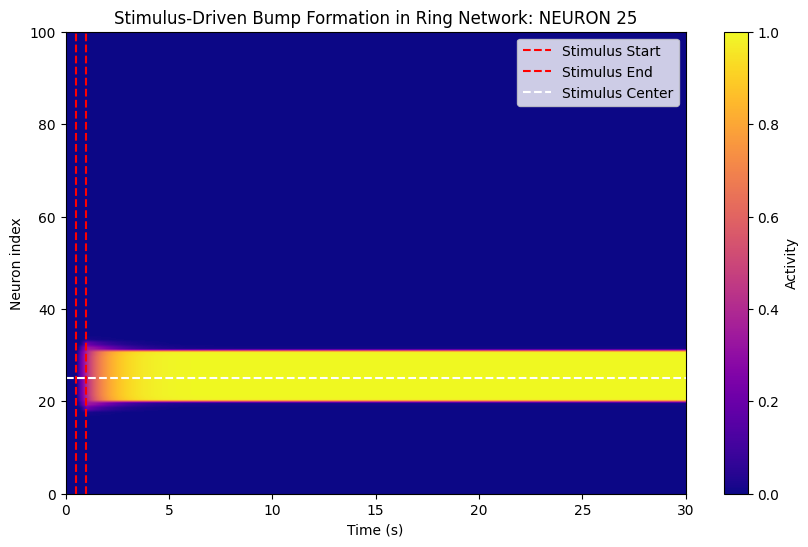

In [160]:
plt.figure(figsize=(10,6))
plt.imshow(r_exc_stim, aspect='auto', origin='lower', cmap='plasma', extent=[0,T,0,N])
plt.colorbar(label='Activity')

# Add labels to clarify when stimulus is delivered as well as the target neuron on the map.
plt.axvline(x=stim_start, color='r', linestyle='--', label='Stimulus Start')
plt.axvline(x=stim_end, color='r', linestyle='--', label='Stimulus End')
plt.axhline(y=stim_center, color='w', linestyle='--', label='Stimulus Center')

# Label My Axis
plt.xlabel('Time (s)')
plt.ylabel('Neuron index')
plt.title('Stimulus-Driven Bump Formation in Ring Network: NEURON 25')
plt.legend()
plt.show()

**Move Stimulation to Neuron 50 and 75**

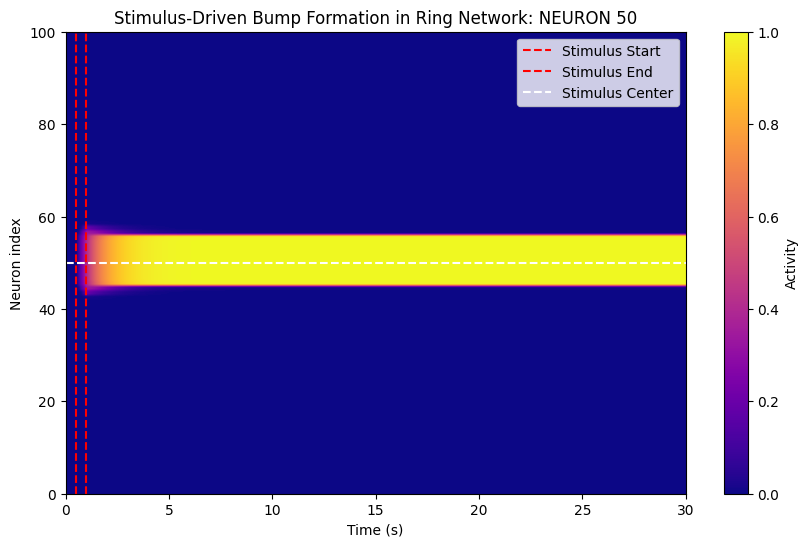

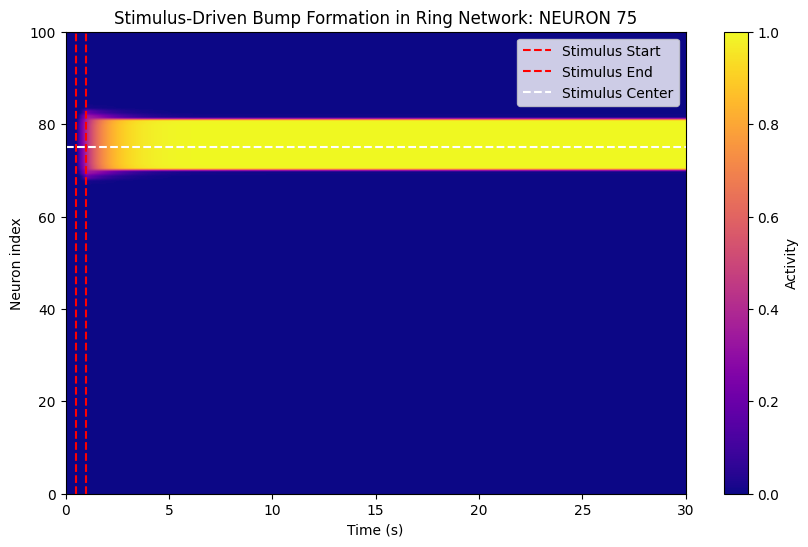

In [161]:
# Stimulus-Driven Bump Formation
dt = 0.01  # Time step
T = 30     # Total simulation time
time = np.arange(0, T+dt, dt)
numSteps = len(time)

# Initialize with small random activity instead of a bump
r_exc_stim = np.zeros((N, numSteps))
r_inh_stim = np.zeros(numSteps)

# Small random initial conditions
r_exc_stim[:, 0] = np.zeros(N)
r_inh_stim[0] = 0.2

# Create external stimulus (Gaussian centered at position 25)
stim_center = 50
stim_width = 5
stim_amplitude = 2
stim_start = 0.5  # Start time of stimulus
stim_end = 1.0    # End time of stimulus

# Create input array for all neurons at all timesteps
I_ext = np.zeros((N, numSteps))

# Set stimulus during the specified time window
stim_start_idx = int(stim_start / dt)
stim_end_idx = int(stim_end / dt)

# Apply stimulus to each neuron based on distance from stimulus center
for i in range(N):
    dist = min(abs(i - stim_center), N - abs(i - stim_center))
    stim_value = stim_amplitude * np.exp(-(dist**2) / (2*stim_width**2))
    I_ext[i, stim_start_idx:stim_end_idx] = stim_value

# Run simulation with external input
r_current = np.zeros(N+1)
for t in range(numSteps-1):
    r_current[0] = r_inh_stim[t]
    r_current[1:] = r_exc_stim[:, t]
    
    # Pass the external input for this time step
    dr = network_dynamics(time[t], r_current, I=I_ext[:, t])
    
    # Update using Euler method
    r_inh_stim[t+1] = r_inh_stim[t] + dt * dr[0]
    r_exc_stim[:, t+1] = r_exc_stim[:, t] + dt * dr[1:]

plt.figure(figsize=(10,6))
plt.imshow(r_exc_stim, aspect='auto', origin='lower', cmap='plasma', extent=[0,T,0,N])
plt.colorbar(label='Activity')
plt.axvline(x=stim_start, color='r', linestyle='--', label='Stimulus Start')
plt.axvline(x=stim_end, color='r', linestyle='--', label='Stimulus End')
plt.axhline(y=stim_center, color='w', linestyle='--', label='Stimulus Center')
plt.xlabel('Time (s)')
plt.ylabel('Neuron index')
plt.title('Stimulus-Driven Bump Formation in Ring Network: NEURON 50')
plt.legend()
plt.show()

# Stimulus-Driven Bump Formation
dt = 0.01  # Time step
T = 30     # Total simulation time
time = np.arange(0, T+dt, dt)
numSteps = len(time)

# Initialize with small random activity instead of a bump
r_exc_stim = np.zeros((N, numSteps))
r_inh_stim = np.zeros(numSteps)

# Small random initial conditions
r_exc_stim[:, 0] = np.zeros(N)
r_inh_stim[0] = 0.2

# Create external stimulus (Gaussian centered at position 25)
stim_center = 75
stim_width = 5
stim_amplitude = 2
stim_start = 0.5  # Start time of stimulus
stim_end = 1.0    # End time of stimulus

# Create input array for all neurons at all timesteps
I_ext = np.zeros((N, numSteps))

# Set stimulus during the specified time window
stim_start_idx = int(stim_start / dt)
stim_end_idx = int(stim_end / dt)

# Apply stimulus to each neuron based on distance from stimulus center
for i in range(N):
    dist = min(abs(i - stim_center), N - abs(i - stim_center))
    stim_value = stim_amplitude * np.exp(-(dist**2) / (2*stim_width**2))
    I_ext[i, stim_start_idx:stim_end_idx] = stim_value

# Run simulation with external input
r_current = np.zeros(N+1)
for t in range(numSteps-1):
    r_current[0] = r_inh_stim[t]
    r_current[1:] = r_exc_stim[:, t]
    
    # Pass the external input for this time step
    dr = network_dynamics(time[t], r_current, I=I_ext[:, t])
    
    # Update using Euler method
    r_inh_stim[t+1] = r_inh_stim[t] + dt * dr[0]
    r_exc_stim[:, t+1] = r_exc_stim[:, t] + dt * dr[1:]

plt.figure(figsize=(10,6))
plt.imshow(r_exc_stim, aspect='auto', origin='lower', cmap='plasma', extent=[0,T,0,N])
plt.colorbar(label='Activity')
plt.axvline(x=stim_start, color='r', linestyle='--', label='Stimulus Start')
plt.axvline(x=stim_end, color='r', linestyle='--', label='Stimulus End')
plt.axhline(y=stim_center, color='w', linestyle='--', label='Stimulus Center')
plt.xlabel('Time (s)')
plt.ylabel('Neuron index')
plt.title('Stimulus-Driven Bump Formation in Ring Network: NEURON 75')
plt.legend()
plt.show()

**Parameter Exploration**
* sigma_w = 1,3 (we've already test 2)
* w_inh = .5, 1, 

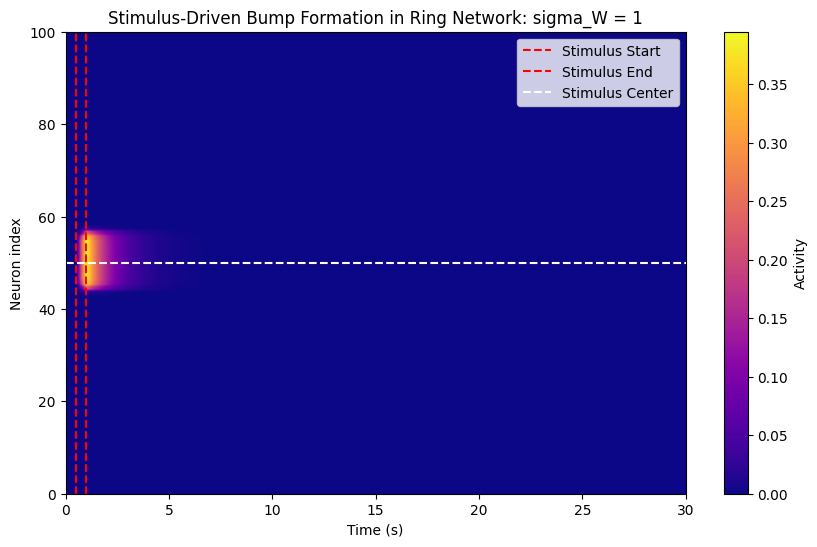

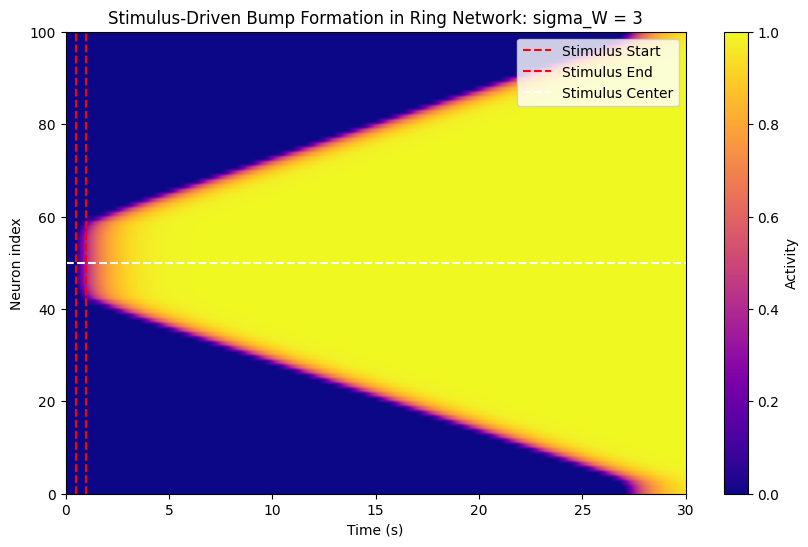

In [163]:
# Explore sigma_w
# We'll have to remake the w matrix each time

#Test sigma_w of 6
sigma_w = 1  # Width of excitatory connections
# Weight Matrix
W = np.zeros((N,N))  # Create N x N matrix of zeros
for i in range(N):
    for j in range(N):
        distance = min(abs(i-j), N-abs(i-j))
        W[i][j] = A * np.exp(-(distance**2)/(2*(sigma_w**2)))
# Stimulus-Driven Bump Formation
dt = 0.01  # Time step
T = 30     # Total simulation time
time = np.arange(0, T+dt, dt)
numSteps = len(time)

# Initialize with small random activity instead of a bump
r_exc_stim = np.zeros((N, numSteps))
r_inh_stim = np.zeros(numSteps)

# Small random initial conditions
r_exc_stim[:, 0] = np.zeros(N)
r_inh_stim[0] = 0.2

# Create external stimulus (Gaussian centered at position 25)
stim_center = 50
stim_width = 5
stim_amplitude = 2
stim_start = 0.5  # Start time of stimulus
stim_end = 1.0    # End time of stimulus

# Create input array for all neurons at all timesteps
I_ext = np.zeros((N, numSteps))

# Set stimulus during the specified time window
stim_start_idx = int(stim_start / dt)
stim_end_idx = int(stim_end / dt)

# Apply stimulus to each neuron based on distance from stimulus center
for i in range(N):
    dist = min(abs(i - stim_center), N - abs(i - stim_center))
    stim_value = stim_amplitude * np.exp(-(dist**2) / (2*stim_width**2))
    I_ext[i, stim_start_idx:stim_end_idx] = stim_value

# Run simulation with external input
r_current = np.zeros(N+1)
for t in range(numSteps-1):
    r_current[0] = r_inh_stim[t]
    r_current[1:] = r_exc_stim[:, t]
    
    # Pass the external input for this time step
    dr = network_dynamics(time[t], r_current, I=I_ext[:, t])
    
    # Update using Euler method
    r_inh_stim[t+1] = r_inh_stim[t] + dt * dr[0]
    r_exc_stim[:, t+1] = r_exc_stim[:, t] + dt * dr[1:]

plt.figure(figsize=(10,6))
plt.imshow(r_exc_stim, aspect='auto', origin='lower', cmap='plasma', extent=[0,T,0,N])
plt.colorbar(label='Activity')
plt.axvline(x=stim_start, color='r', linestyle='--', label='Stimulus Start')
plt.axvline(x=stim_end, color='r', linestyle='--', label='Stimulus End')
plt.axhline(y=stim_center, color='w', linestyle='--', label='Stimulus Center')
plt.xlabel('Time (s)')
plt.ylabel('Neuron index')
plt.title('Stimulus-Driven Bump Formation in Ring Network: sigma_W = 1')
plt.legend()
plt.show()

#Test sigma_w of 3
sigma_w = 3  # Width of excitatory connections
# Weight Matrix
W = np.zeros((N,N))  # Create N x N matrix of zeros
for i in range(N):
    for j in range(N):
        distance = min(abs(i-j), N-abs(i-j))
        W[i][j] = A * np.exp(-(distance**2)/(2*(sigma_w**2)))
# Stimulus-Driven Bump Formation
dt = 0.01  # Time step
T = 30     # Total simulation time
time = np.arange(0, T+dt, dt)
numSteps = len(time)

# Initialize with small random activity instead of a bump
r_exc_stim = np.zeros((N, numSteps))
r_inh_stim = np.zeros(numSteps)

# Small random initial conditions
r_exc_stim[:, 0] = np.zeros(N)
r_inh_stim[0] = 0.2

# Create external stimulus (Gaussian centered at position 25)
stim_center = 50
stim_width = 5
stim_amplitude = 2
stim_start = 0.5  # Start time of stimulus
stim_end = 1.0    # End time of stimulus

# Create input array for all neurons at all timesteps
I_ext = np.zeros((N, numSteps))

# Set stimulus during the specified time window
stim_start_idx = int(stim_start / dt)
stim_end_idx = int(stim_end / dt)

# Apply stimulus to each neuron based on distance from stimulus center
for i in range(N):
    dist = min(abs(i - stim_center), N - abs(i - stim_center))
    stim_value = stim_amplitude * np.exp(-(dist**2) / (2*stim_width**2))
    I_ext[i, stim_start_idx:stim_end_idx] = stim_value

# Run simulation with external input
r_current = np.zeros(N+1)
for t in range(numSteps-1):
    r_current[0] = r_inh_stim[t]
    r_current[1:] = r_exc_stim[:, t]
    
    # Pass the external input for this time step
    dr = network_dynamics(time[t], r_current, I=I_ext[:, t])
    
    # Update using Euler method
    r_inh_stim[t+1] = r_inh_stim[t] + dt * dr[0]
    r_exc_stim[:, t+1] = r_exc_stim[:, t] + dt * dr[1:]

plt.figure(figsize=(10,6))
plt.imshow(r_exc_stim, aspect='auto', origin='lower', cmap='plasma', extent=[0,T,0,N])
plt.colorbar(label='Activity')
plt.axvline(x=stim_start, color='r', linestyle='--', label='Stimulus Start')
plt.axvline(x=stim_end, color='r', linestyle='--', label='Stimulus End')
plt.axhline(y=stim_center, color='w', linestyle='--', label='Stimulus Center')
plt.xlabel('Time (s)')
plt.ylabel('Neuron index')
plt.title('Stimulus-Driven Bump Formation in Ring Network: sigma_W = 3')
plt.legend()
plt.show()

What we see here is interesting, if we decrease the width of excitatory connections from 2 to 1, the network never stabilizes. It reaches a level of activity within a narrow range of neurons and it quickly begins to dissapate and activity returns to a resting state. On the hand, if we increase the width from 2 to 3, we see that the network experiences over excitation. In otherwords, all neurons become maximally active. This illustrates the careful balance between excitation and inhibition in these networks.

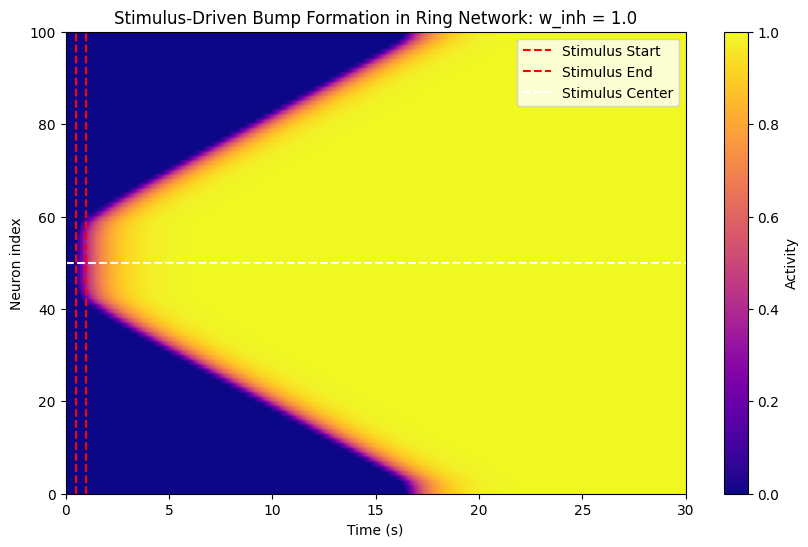

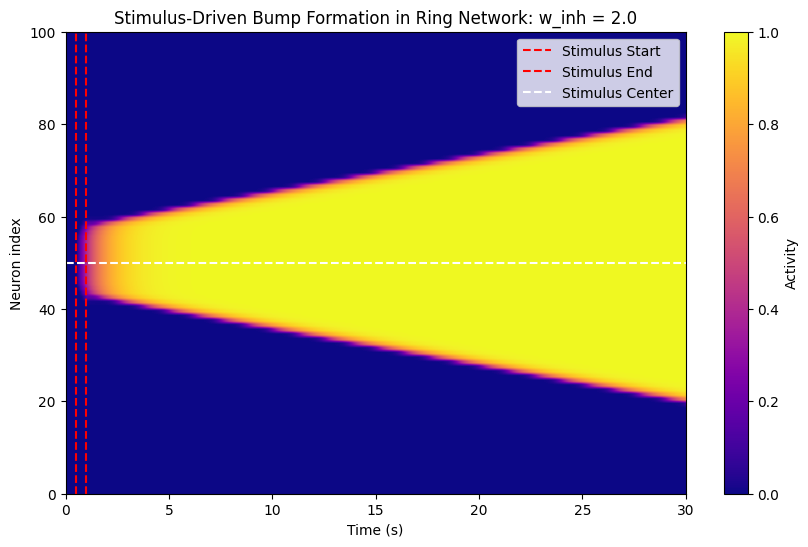

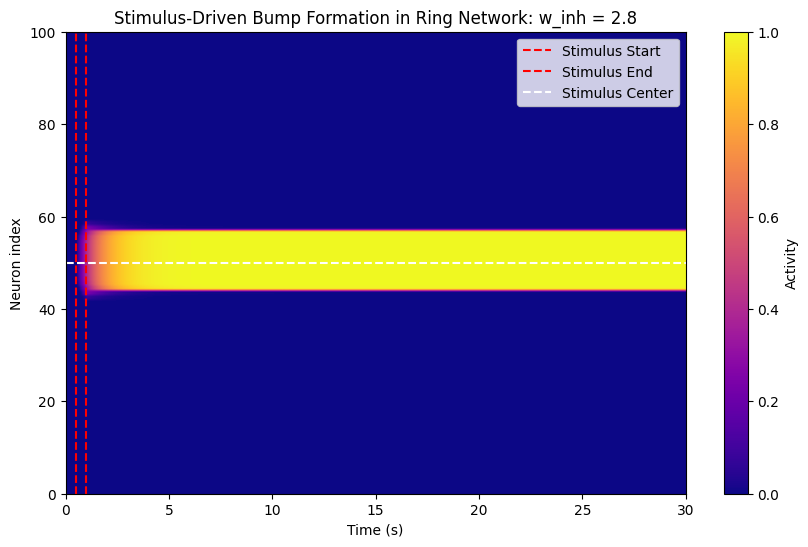

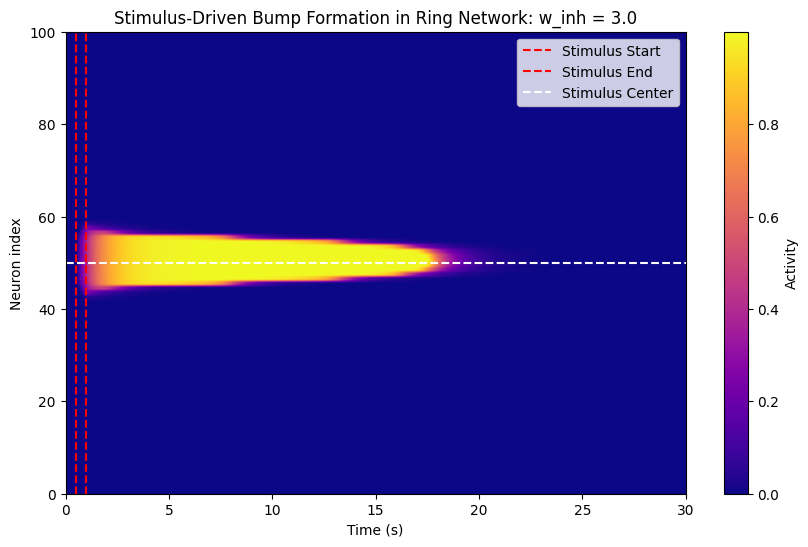

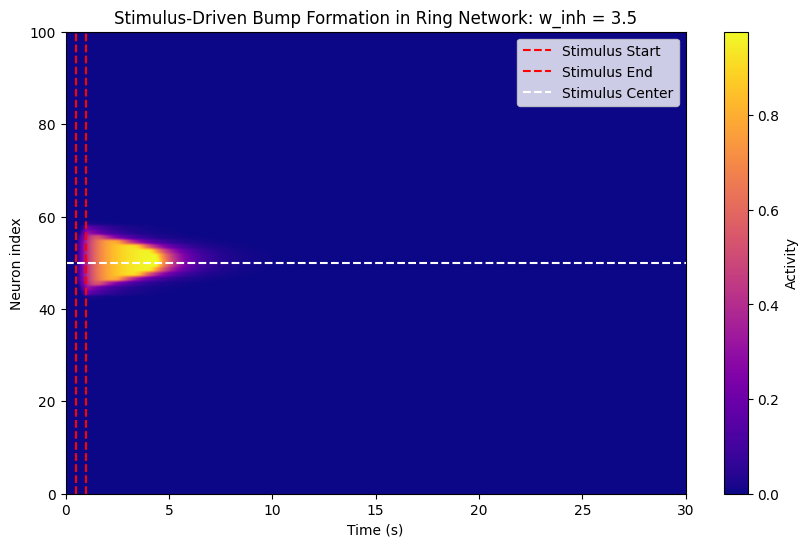

In [165]:
# Vary w_inh values
w_inh_values = [1.0, 2.0, 2.8, 3.0, 3.5]

# Set up w matrix with original weights
sigma_w = 3  # Width of excitatory connections. 
# Weight Matrix
W = np.zeros((N,N))  # Create N x N matrix of zeros
for i in range(N):
    for j in range(N):
        distance = min(abs(i-j), N-abs(i-j))
        W[i][j] = A * np.exp(-(distance**2)/(2*(sigma_w**2)))

for x in w_inh_values:
    w_inh = x
    # Run simulation with external input
    r_current = np.zeros(N+1)
    for t in range(numSteps-1):
        r_current[0] = r_inh_stim[t]
        r_current[1:] = r_exc_stim[:, t]
        
        # Pass the external input for this time step
        dr = network_dynamics(time[t], r_current, I=I_ext[:, t])
        
        # Update using Euler method
        r_inh_stim[t+1] = r_inh_stim[t] + dt * dr[0]
        r_exc_stim[:, t+1] = r_exc_stim[:, t] + dt * dr[1:]
    
    plt.figure(figsize=(10,6))
    plt.imshow(r_exc_stim, aspect='auto', origin='lower', cmap='plasma', extent=[0,T,0,N])
    plt.colorbar(label='Activity')
    plt.axvline(x=stim_start, color='r', linestyle='--', label='Stimulus Start')
    plt.axvline(x=stim_end, color='r', linestyle='--', label='Stimulus End')
    plt.axhline(y=stim_center, color='w', linestyle='--', label='Stimulus Center')
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron index')
    plt.title('Stimulus-Driven Bump Formation in Ring Network: w_inh = {}'.format(str(x)))
    plt.legend()
    plt.show()
    

Varying w_inh shows highlights the necessity of the central inhitory neuron to stabilize the bump in activity. In this simulation an inhitory strength of 2.8 was the stabilizing level. Inhition weaker than this led to over excitation of the network. In this scenario all neurons reached maximal excitation. On the other hand, in our two examples where w_inh was greater than 2.8 what we see is over inhibition of the network and it once again never reaches a stabel level of activity. Note: In the original simulations, the width of excitatory connections was set to 2 so a smaller w_inh value, 1.8, was the stabilizing point. In this example the width of excitatory connections is 3 so the network stabilizes at a greater w_inh value 2.8.

**Part C: Analysis and Discussion**
* Why is the central inhibitory neuron necessary for stabilizing the bump? 
  It provides global feedback inhibition. Without its input, excitation from the bump will spread to all neurons in the network. This is highlighted in our example in which inhitory input was too weak and all neurons become maximally active.
* What happens when w_inh = 0, When Wo = 0? 
  As hinted at previously, when there is no inhibition, the excitation will spread throughout the entire network. Instead of stabilizing at a particular activity level, all neurons in the network become maximally activated. When w_inh is 0 the inhition strength is non existent. When W_theta is 0 the excitatory input to the center neuron is nonexistent. As a result, it never becomes active in response to excitation in the outer ring of neurons.
* Can the network support multiple bumps? 
  Yes the network can support multiple bumps. To illustrate this point, see the simulation in the next cell. What I find is that the second bump must be greater in magnitude than the first to overcome the inhibition from the first pulse.
* Under what conditions does the bump drift or dissipate? 
  It will dissapate or drift when inhition from the center neuron is too great. If this inhition far exceed excitation, activity will not spread to other neurons outside in the network, but those neurons that were activated originally will eventually become inactive and the network fails to stabilize at any level other than 0.

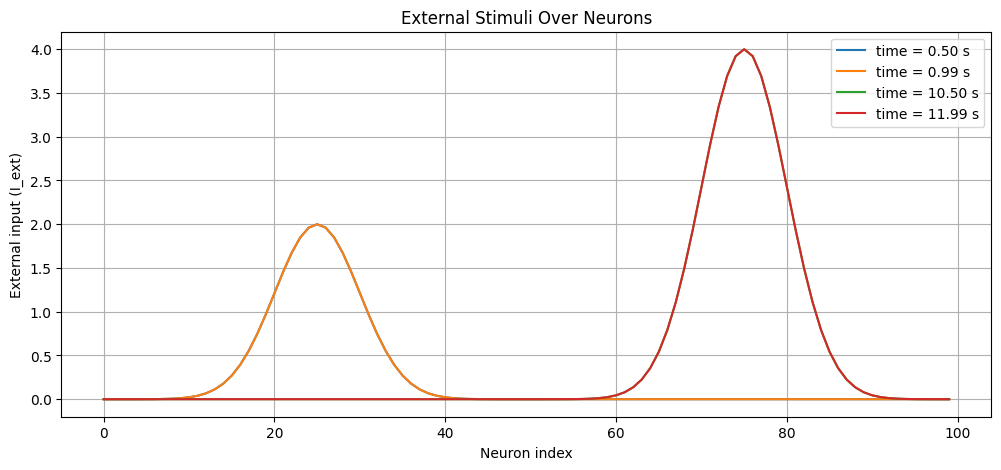

In [170]:
# Make our new stimulus array with two pulses

# Create external stimulus (Two Gaussian pulses)
# First stimulus center
stim_center1 = 25
# Second stimulus center
stim_center2 = 75
stim_width = 5
stim_amplitude1 = 2  # Amplitude for first stimulus
stim_amplitude2 = 4  # Amplitude for second stimulus
stim_start1 = 0.5  # Start time of first stimulus
stim_end1 = 1.0    # End time of first stimulus
stim_start2 = 10.5  # Start time of second stimulus
stim_end2 = 12.0    # End time of second stimulus

# Create input array for all neurons at all timesteps
I_ext = np.zeros((N, numSteps))

# Function to apply stimulus
def apply_stimulus(I_ext, stim_center, stim_width, stim_amplitude, stim_start_idx, stim_end_idx):
    for i in range(N):
        # Calculate the shortest distance (accounting for periodic boundary)
        dist = min(abs(i - stim_center), N - abs(i - stim_center))
        stim_value = stim_amplitude * np.exp(-(dist**2) / (2*stim_width**2))
        I_ext[i, stim_start_idx:stim_end_idx] = stim_value
    return I_ext

# Convert start and end times to indices
stim_start1_idx = int(stim_start1 / dt)
stim_end1_idx = int(stim_end1 / dt)
stim_start2_idx = int(stim_start2 / dt)
stim_end2_idx = int(stim_end2 / dt)

# Apply first stimulus
I_ext = apply_stimulus(I_ext, stim_center1, stim_width, stim_amplitude1, 
                       stim_start1_idx, stim_end1_idx)

# Apply second stimulus
I_ext = apply_stimulus(I_ext, stim_center2, stim_width, stim_amplitude2, 
                       stim_start2_idx, stim_end2_idx)

import matplotlib.pyplot as plt

# Plot external input at selected time points
plt.figure(figsize=(12, 5))
for t in [stim_start1_idx, stim_end1_idx - 1, stim_start2_idx, stim_end2_idx - 1]:
    plt.plot(I_ext[:, t], label=f'time = {t * dt:.2f} s')
plt.xlabel('Neuron index')
plt.ylabel('External input (I_ext)')
plt.title('External Stimuli Over Neurons')
plt.legend()
plt.grid(True)
plt.show()



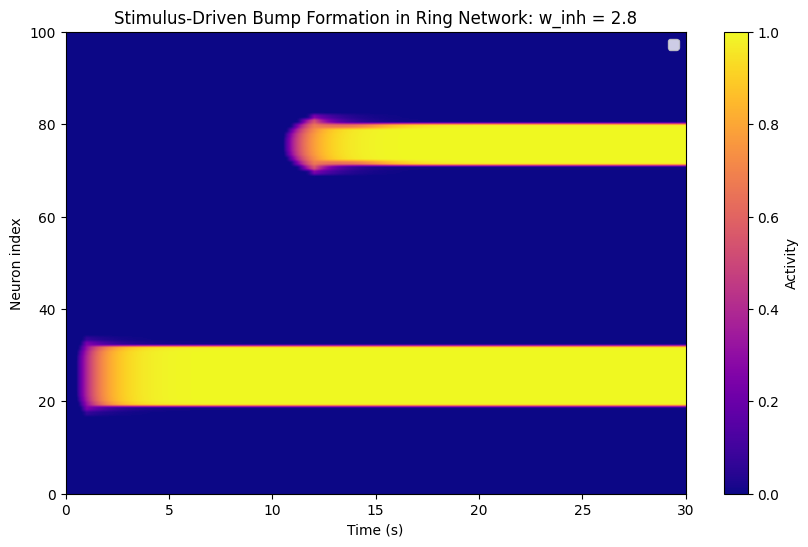

In [171]:
# Re use code from last simulation
w_inh_values = [2.8] # We know this is the stable inhibition strength

# Set up w matrix with original weights
sigma_w = 3  # Width of excitatory connections



W = np.zeros((N,N))  # Create N x N matrix of zeros
for i in range(N):
    for j in range(N):
        distance = min(abs(i-j), N-abs(i-j))
        W[i][j] = A * np.exp(-(distance**2)/(2*(sigma_w**2)))

for x in w_inh_values:
    w_inh = x
    # Run simulation with external input
    r_current = np.zeros(N+1)
    for t in range(numSteps-1):
        r_current[0] = r_inh_stim[t]
        r_current[1:] = r_exc_stim[:, t]
        
        # Pass the external input for this time step
        dr = network_dynamics(time[t], r_current, I=I_ext[:, t])
        
        # Update using Euler method
        r_inh_stim[t+1] = r_inh_stim[t] + dt * dr[0]
        r_exc_stim[:, t+1] = r_exc_stim[:, t] + dt * dr[1:]
    
    plt.figure(figsize=(10,6))
    plt.imshow(r_exc_stim, aspect='auto', origin='lower', cmap='plasma', extent=[0,T,0,N])
    plt.colorbar(label='Activity')
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron index')
    plt.title('Stimulus-Driven Bump Formation in Ring Network: w_inh = {}'.format(str(x)))
    plt.legend()
    plt.show()
    

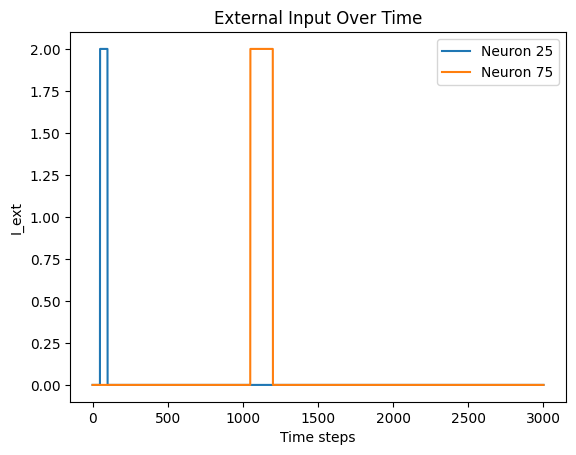

In [169]:
# Visualize stimulus
plt.plot(I_ext[stim_center1, :], label=f'Neuron {stim_center1}')
plt.plot(I_ext[stim_center2, :], label=f'Neuron {stim_center2}')
plt.xlabel("Time steps")
plt.ylabel("I_ext")
plt.legend()
plt.title("External Input Over Time")
plt.show()


# Problem 2: Transition to Chaos in Random Neural Net-works